In [91]:
%matplotlib inline
import math
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from collections import defaultdict
from scipy.stats import pearsonr
import pandas as pd
from IPython.display import display

# Load calc agg features

In [92]:
DATA_DIR = r"Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data"

DATASETS = {
    "heart_diagnoses_1": "heart_diagnoses_1.csv",
    "laboratory_events_codes_2": "laboratory_events_codes_2.csv",
    "microbiology_events_codes_3": "microbiology_events_codes_3.csv",
    "procedure_code_4": "procedure_code_4.csv",
}

In [93]:
dfs = [pd.read_csv(f"{DATA_DIR}/{DATASETS[dataset].replace('.csv', '_agg_features.csv')}") for dataset in DATASETS.keys()]
len(dfs)

4

In [94]:
for df, name in zip(dfs, DATASETS.keys()):
    print(f"\nDataset: {name}")
    print("="*80)
    print(f"Shape: {df.shape}")
    print("Columns:")
    display(df.head(2))
    display(df.describe())


Dataset: heart_diagnoses_1
Shape: (4864, 10)
Columns:


,subject_id,hadm_id,has_heartnotes,age,gender,is_dead,num_imaging_tests,num_unique_icd,note_time_span_hours,hpi_length
0,10000980,26913865,1,75.0,F,1,4,1,0.0,1058.0
1,10000980,29654838,1,75.0,F,1,3,1,0.0,770.0


,subject_id,hadm_id,has_heartnotes,age,is_dead,num_imaging_tests,num_unique_icd,note_time_span_hours,hpi_length
count,4.864000e+03,4.864000e+03,4864.0,1363.000000,4864.000000,4864.000000,4864.0,4864.0,4864.000000
mean,1.510717e+07,2.501745e+07,1.0,68.978723,0.081826,3.297081,1.0,0.0,1728.680715
std,2.938761e+06,2.873736e+06,0.0,14.973358,0.274127,0.529166,0.0,0.0,676.873262
min,1.000098e+07,2.000446e+07,1.0,18.000000,0.000000,2.000000,1.0,0.0,21.000000
25%,1.252385e+07,2.260252e+07,1.0,60.000000,0.000000,3.000000,1.0,0.0,1281.000000
50%,1.507553e+07,2.503238e+07,1.0,70.000000,0.000000,3.000000,1.0,0.0,1667.000000
75%,1.764939e+07,2.746833e+07,1.0,81.000000,0.000000,4.000000,1.0,0.0,2099.500000
max,1.999860e+07,2.999967e+07,1.0,95.000000,1.000000,6.000000,1.0,0.0,9085.000000



Dataset: laboratory_events_codes_2
Shape: (4855, 50)
Columns:


,subject_id,hadm_id,num_labs,abnormal_ratio,qc_fail_ratio,lab_time_span_hours,unique_lab_tests,has_labs,max_glucose,min_glucose,...,max_hemoglobin,min_hemoglobin,max_hematocrit,min_hematocrit,max_rbc,min_rbc,max_rdw,min_rdw,max_sodium,min_sodium
0,10000980,26913865.0,166,0.0,0.024096,140.466667,45,1,9.0465,4.551,...,101.0,6.8,30.8,23.6,NaN,NaN,13.4,12.9,143.0,139.0
1,10000980,29654838.0,59,0.0,0.000000,33.433333,35,1,7.6590,5.328,...,99.0,8.1,31.4,29.8,NaN,NaN,14.6,14.5,146.0,144.0


,subject_id,hadm_id,num_labs,abnormal_ratio,qc_fail_ratio,lab_time_span_hours,unique_lab_tests,has_labs,max_glucose,min_glucose,...,max_hemoglobin,min_hemoglobin,max_hematocrit,min_hematocrit,max_rbc,min_rbc,max_rdw,min_rdw,max_sodium,min_sodium
count,4.855000e+03,4.855000e+03,4855.000000,4855.000000,4855.000000,4855.000000,4855.000000,4855.0,4823.000000,4823.000000,...,4807.000000,4807.000000,4825.000000,4825.000000,1004.000000,1004.000000,4807.000000,4807.000000,4827.000000,4827.000000
mean,1.510805e+07,2.501709e+07,240.493306,0.000086,0.020154,115.134343,47.647168,1.0,14.167228,5.463994,...,122.663033,85.390971,37.373451,32.514756,8760.829681,3819.909363,23.993073,14.557416,141.070851,124.630619
std,2.939544e+06,2.874953e+06,513.277369,0.000800,0.014587,111.872999,21.559055,0.0,31.014046,1.668278,...,20.089755,46.308441,5.519217,6.703981,62736.961835,40348.783846,15.799367,1.908098,3.640490,31.924754
min,1.000098e+07,2.000446e+07,3.000000,0.000000,0.000000,0.000000,3.000000,1.0,2.553000,0.000000,...,4.800000,0.000000,19.000000,0.000000,0.000000,0.000000,11.400000,11.200000,122.000000,10.000000
25%,1.251722e+07,2.260072e+07,79.000000,0.000000,0.011236,44.233333,31.000000,1.0,6.382500,4.606500,...,108.000000,71.500000,33.400000,28.000000,1.000000,1.000000,14.000000,13.300000,139.000000,132.000000
50%,1.507734e+07,2.503202e+07,136.000000,0.000000,0.019002,81.100000,43.000000,1.0,8.269500,5.161500,...,122.000000,99.000000,37.300000,32.800000,3.000000,2.000000,15.500000,14.100000,141.000000,136.000000
75%,1.765293e+07,2.746949e+07,259.000000,0.000000,0.027141,149.150000,60.000000,1.0,11.599500,5.938500,...,137.000000,119.000000,41.200000,37.200000,7.000000,4.000000,38.350000,15.400000,143.000000,139.000000
max,1.999860e+07,2.999967e+07,22580.000000,0.019802,0.285714,1257.800000,175.000000,1.0,1190.000000,24.531000,...,201.000000,182.000000,61.200000,55.000000,886449.000000,799243.000000,100.000000,46.300000,212.000000,152.000000



Dataset: microbiology_events_codes_3
Shape: (2756, 7)
Columns:


,subject_id,hadm_id,has_micro,total_microbio_events,unique_specimen_types,unique_organisms,resistant_ratio
0,10000980,26913865,1,1,1,0,0.0
1,10002155,23822395,1,12,4,0,0.0


,subject_id,hadm_id,has_micro,total_microbio_events,unique_specimen_types,unique_organisms,resistant_ratio
count,2.756000e+03,2.756000e+03,2756.0,2756.000000,2756.000000,2756.000000,2756.000000
mean,1.561649e+07,2.503819e+07,1.0,5.655298,2.033745,0.356313,0.022155
std,3.105062e+06,2.879683e+06,0.0,8.387583,1.431543,0.715932,0.097512
min,1.000098e+07,2.000790e+07,1.0,1.000000,1.000000,0.000000,0.000000
25%,1.294230e+07,2.262280e+07,1.0,1.000000,1.000000,0.000000,0.000000
50%,1.569462e+07,2.506436e+07,1.0,2.500000,2.000000,0.000000,0.000000
75%,1.847125e+07,2.752187e+07,1.0,7.000000,3.000000,1.000000,0.000000
max,1.999767e+07,2.999967e+07,1.0,122.000000,15.000000,9.000000,1.000000



Dataset: procedure_code_4
Shape: (3459, 6)
Columns:


,subject_id,hadm_id,has_procedure,total_procedures,unique_icd_codes,procedure_span_days
0,10000980,26913865,1,7,7,0.0
1,10002013,24760295,1,2,2,0.0


,subject_id,hadm_id,has_procedure,total_procedures,unique_icd_codes,procedure_span_days
count,3.459000e+03,3.459000e+03,3459.0,3459.000000,3459.000000,3459.000000
mean,1.499381e+07,2.502943e+07,1.0,4.191096,4.058398,1.442324
std,2.868527e+06,2.853466e+06,0.0,2.989024,2.717689,3.541510
min,1.000098e+07,2.000790e+07,1.0,1.000000,1.000000,0.000000
25%,1.249509e+07,2.264270e+07,1.0,2.000000,2.000000,0.000000
50%,1.495295e+07,2.506423e+07,1.0,3.000000,3.000000,0.000000
75%,1.747168e+07,2.747180e+07,1.0,6.000000,6.000000,1.000000
max,1.999850e+07,2.999967e+07,1.0,28.000000,21.000000,43.000000


# Merge

In [95]:
from functools import reduce

# Merge all on ['subject_id', 'hadm_id']
patient_profile = reduce(
    lambda left, right: pd.merge(left, right, on=['subject_id', 'hadm_id'], how='outer'),
    dfs
)

In [96]:
# Targeted NA handling
has_cols = [c for c in patient_profile.columns if c.startswith('has_')]
print(has_cols)
# Fill indicators with 0 (absent)
patient_profile[has_cols] = patient_profile[has_cols].fillna(0).astype(int)

['has_heartnotes', 'has_labs', 'has_micro', 'has_procedure']


In [97]:
# Identify numeric columns (exclude ids/flags)
numeric_cols = [c for c in patient_profile.select_dtypes(include='number').columns
                if c not in ('subject_id', 'hadm_id')]

# Heuristic: detect count-like columns and fill zeros when corresponding has_* indicates absence
count_like_keywords = ('num_', 'total_', 'unique_', 'n_', 'count', '_count')
count_cols = [c for c in numeric_cols if any(k in c for k in count_like_keywords)]

In [98]:
# mapping heuristics from feature name -> has_ flag (extend if needed)
map_keywords = {
    'lab': 'has_labs',
    'micro': 'has_micro',
    'procedure': 'has_procedure',
    'proc': 'has_procedure',
    'note': 'has_heartnotes',
    'imaging': 'has_imaging'  # if you ever create has_imaging
}

for col in count_cols:
    filled = False
    lname = col.lower()
    for key, has_flag in map_keywords.items():
        if key in lname and has_flag in patient_profile.columns:
            patient_profile.loc[patient_profile[has_flag] == 0, col] = 0
            filled = True
            break
    if not filled:
        # safe fallback: fill remaining NaNs with 0 (counts mean absence)
        patient_profile[col] = patient_profile[col].fillna(0)

# Measurements / statistics: keep NaN but create missing indicators
exclude_from_measure = set(count_cols) | set(has_cols) | {'subject_id', 'hadm_id'}
measurement_cols = [c for c in numeric_cols if c not in exclude_from_measure and c != 'is_dead']

for c in measurement_cols:
    patient_profile[c + '_missing'] = patient_profile[c].isna().astype(int)

In [99]:
patient_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 93 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subject_id                      5166 non-null   int64  
 1   hadm_id                         5166 non-null   int64  
 2   has_heartnotes                  5166 non-null   int64  
 3   age                             1363 non-null   float64
 4   gender                          4858 non-null   object 
 5   is_dead                         4864 non-null   float64
 6   num_imaging_tests               5166 non-null   float64
 7   num_unique_icd                  5166 non-null   float64
 8   note_time_span_hours            5166 non-null   float64
 9   hpi_length                      4864 non-null   float64
 10  num_labs                        5166 non-null   float64
 11  abnormal_ratio                  4855 non-null   float64
 12  qc_fail_ratio                   48

In [100]:
patient_profile.head()

,subject_id,hadm_id,has_heartnotes,age,gender,is_dead,num_imaging_tests,num_unique_icd,note_time_span_hours,hpi_length,...,max_c-reactive protein_missing,max_ast_missing,max_alt_missing,max_ld_missing,max_hemoglobin_missing,max_hematocrit_missing,max_rbc_missing,max_rdw_missing,max_sodium_missing,resistant_ratio_missing
0,10000980,26913865,1,75.0,F,1.0,4.0,1.0,0.0,1058.0,...,1,0,0,1,0,0,1,0,0,0
1,10000980,29654838,1,75.0,F,1.0,3.0,1.0,0.0,770.0,...,1,0,0,0,0,0,1,0,0,1
2,10002013,24760295,1,NaN,F,0.0,4.0,1.0,0.0,2007.0,...,1,1,1,1,0,0,1,0,0,1
3,10002155,23822395,1,NaN,F,0.0,3.0,1.0,0.0,1752.0,...,1,1,1,1,0,0,1,0,0,0
4,10004457,28723315,1,66.0,M,0.0,3.0,1.0,0.0,1783.0,...,1,1,1,0,0,0,1,0,1,1


# Completeness Analysis

In [101]:
# Identify the 'has_' indicator columns
has_columns = [col for col in patient_profile.columns if col.startswith('has_')]
print(f"Data source indicators: {has_columns}")

Data source indicators: ['has_heartnotes', 'has_labs', 'has_micro', 'has_procedure']



COMPLETENESS SUMMARY

Per-Source Availability:
  has_heartnotes: 4,864 patients (94.2%)
  has_labs: 4,855 patients (94.0%)
  has_micro: 2,756 patients (53.3%)
  has_procedure: 3,459 patients (67.0%)

--------------------------------------------------------------------------------
DATA SOURCE COMBINATIONS:
--------------------------------------------------------------------------------
  [1-1-1-1] heartnotes, labs, micro, procedure: 1,932 (37.4%)
  [1-1-0-1] heartnotes, labs, procedure: 1,525 (29.5%)
  [1-1-0-0] heartnotes, labs: 876 (17.0%)
  [1-1-1-0] heartnotes, labs, micro: 522 (10.1%)
  [0-0-1-0] micro: 302 (5.8%)
  [1-0-0-0] heartnotes: 7 (0.1%)
  [1-0-0-1] heartnotes, procedure: 2 (0.0%)


C:\Users\dgars\AppData\Local\Temp\ipykernel_30916\1571333312.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(sources, rotation=45, ha='right')


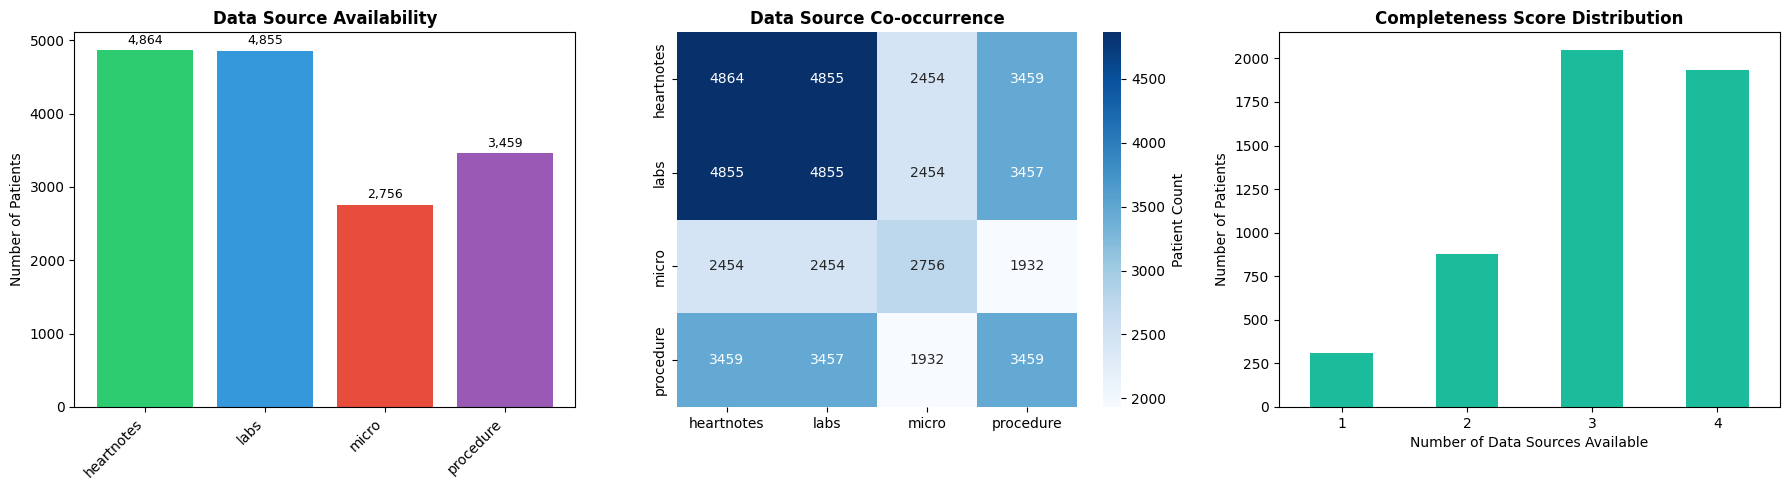


COMPLETENESS SCORE SUMMARY

Total patients: 5,166
Patients with ALL sources: 1,932
Patients with NO sources: 0
Average sources per patient: 3.08


In [102]:
# Completeness Matrix - Check which data sources are available for each patient
completeness = patient_profile[has_columns].copy()

# Summary statistics
print("\n" + "="*80)
print("COMPLETENESS SUMMARY")
print("="*80)

# Per-source completeness
print("\nPer-Source Availability:")
for col in has_columns:
    count = (patient_profile[col] == 1).sum()
    pct = count / len(patient_profile) * 100
    print(f"  {col}: {count:,} patients ({pct:.1f}%)")

# Combination completeness
print("\n" + "-"*80)
print("DATA SOURCE COMBINATIONS:")
print("-"*80)

# Create a combined key for each row
completeness['combination'] = completeness[has_columns].astype(int).astype(str).agg('-'.join, axis=1)
combo_counts = completeness['combination'].value_counts()

# Create readable labels
for combo, count in combo_counts.items():
    sources = [has_columns[i].replace('has_', '') for i, val in enumerate(combo.split('-')) if val == '1']
    sources_str = ', '.join(sources) if sources else 'None'
    pct = count / len(patient_profile) * 100
    print(f"  [{combo}] {sources_str}: {count:,} ({pct:.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Bar chart of individual source availability
ax1 = axes[0]
source_counts = [(col.replace('has_', ''), (patient_profile[col] == 1).sum()) for col in has_columns]
sources, counts = zip(*source_counts)
bars = ax1.bar(sources, counts, color=['#2ecc71', '#3498db', '#e74c3c', '#9b59b6'][:len(has_columns)])
ax1.set_ylabel('Number of Patients')
ax1.set_title('Data Source Availability', fontweight='bold')
ax1.set_xticklabels(sources, rotation=45, ha='right')
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count:,}', ha='center', va='bottom', fontsize=9)

# Plot 2: Heatmap of co-occurrence
ax2 = axes[1]
cooccurrence = pd.DataFrame(index=has_columns, columns=has_columns, dtype=float)
for col1 in has_columns:
    for col2 in has_columns:
        both = ((patient_profile[col1] == 1) & (patient_profile[col2] == 1)).sum()
        cooccurrence.loc[col1, col2] = both

# Rename for display
cooccurrence.index = [c.replace('has_', '') for c in cooccurrence.index]
cooccurrence.columns = [c.replace('has_', '') for c in cooccurrence.columns]

sns.heatmap(cooccurrence.astype(float), annot=True, fmt='.0f', cmap='Blues', 
            ax=ax2, cbar_kws={'label': 'Patient Count'})
ax2.set_title('Data Source Co-occurrence', fontweight='bold')

# Plot 3: Completeness score distribution
ax3 = axes[2]
patient_profile['completeness_score'] = patient_profile[has_columns].sum(axis=1)
patient_profile['completeness_score'].value_counts().sort_index().plot(kind='bar', ax=ax3, color='#1abc9c')
ax3.set_xlabel('Number of Data Sources Available')
ax3.set_ylabel('Number of Patients')
ax3.set_title('Completeness Score Distribution', fontweight='bold')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(r'../plots/1.2_completeness_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Final summary
print("\n" + "="*80)
print("COMPLETENESS SCORE SUMMARY")
print("="*80)
print(f"\nTotal patients: {len(patient_profile):,}")
print(f"Patients with ALL sources: {(patient_profile['completeness_score'] == len(has_columns)).sum():,}")
print(f"Patients with NO sources: {(patient_profile['completeness_score'] == 0).sum():,}")
print(f"Average sources per patient: {patient_profile['completeness_score'].mean():.2f}")

# Save big patient profile

In [103]:
patient_profile.to_csv(os.path.join(DATA_DIR, "patient_profile_large.csv"), index=False)

# Corr

In [104]:
patient_profile.columns

Index(['subject_id', 'hadm_id', 'has_heartnotes', 'age', 'gender', 'is_dead',
       'num_imaging_tests', 'num_unique_icd', 'note_time_span_hours',
       'hpi_length', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio',
       'lab_time_span_hours', 'unique_lab_tests', 'has_labs', 'max_glucose',
       'min_glucose', 'max_lactate', 'min_lactate', 'max_anion gap',
       'min_anion gap', 'max_bicarbonate', 'min_bicarbonate', 'max_creatinine',
       'min_creatinine', 'max_urea nitrogen', 'min_urea nitrogen',
       'max_phosphate', 'min_phosphate', 'max_potassium', 'min_potassium',
       'max_pO2', 'min_pO2', 'max_pCO2', 'min_pCO2', 'max_pH', 'min_pH',
       'max_base excess', 'min_base excess', 'max_c-reactive protein',
       'min_c-reactive protein', 'max_ast', 'min_ast', 'max_alt', 'min_alt',
       'max_ld', 'min_ld', 'max_hemoglobin', 'min_hemoglobin',
       'max_hematocrit', 'min_hematocrit', 'max_rbc', 'min_rbc', 'max_rdw',
       'min_rdw', 'max_sodium', 'min_sodium', 'has_micro

In [105]:
def corr_report(df, features, data_dir=None, plot_name='selected_features_corr.png', threshold=0.60, figsize=(12,10), show_plot=True):
    """
    Compute correlation matrix for given features in df, plot heatmap, and return correlations + high-corr pairs.
    Args:
      df : pandas.DataFrame
      features : list of column names to consider (will keep only existing)
      data_dir : optional base dir to save plot (if None uses cwd)
      plot_name : filename for saved plot (saved into <data_dir>/plots/)
      threshold : float, absolute correlation threshold to report pairs
      figsize : tuple, matplotlib figure size
      show_plot : bool, whether to plt.show()
    Returns:
      corr_df : pandas.DataFrame (correlation matrix)
      high_pairs : list of tuples (col1, col2, corr_value)
      used_features : list of features actually used for numeric corr
    """
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd

    # keep only existing requested cols
    sel = [c for c in features if c in df.columns]
    if not sel:
        raise ValueError("No requested features found in dataframe.")

    tmp = df[sel].copy()

    # simple encoding for common categorical used here
    if 'gender' in tmp.columns:
        tmp['gender_enc'] = tmp['gender'].map({'M':1, 'F':0}).fillna(-1)
        tmp = tmp.drop(columns=['gender'])

    # booleans -> int
    for c in tmp.columns:
        if tmp[c].dtype == 'bool':
            tmp[c] = tmp[c].astype(int)

    # select numeric columns only
    num_tmp = tmp.select_dtypes(include=[np.number]).copy()
    used_features = num_tmp.columns.tolist()
    if len(used_features) < 2:
        raise ValueError("Need at least two numeric features for correlation. Numeric found: " + ", ".join(used_features))

    # correlation
    corr_df = num_tmp.corr()

    # plot heatmap (mask upper triangle)
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    sns.heatmap(corr_df, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                cbar_kws={'label':'corr'})
    plt.title('Correlation matrix — selected features')
    plt.tight_layout()

    # save
    if data_dir is None:
        save_dir = os.path.abspath('.')
    else:
        save_dir = data_dir
    plots_dir = os.path.join(save_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    save_path = os.path.join(plots_dir, plot_name)
    plt.savefig(save_path, dpi=200, bbox_inches='tight')

    if show_plot:
        plt.show()
    else:
        plt.close()

    # extract high-correlation pairs (upper triangle only)
    cols = corr_df.columns.tolist()
    high_pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            val = corr_df.iloc[i, j]
            if pd.notna(val) and abs(val) >= threshold:
                high_pairs.append((cols[i], cols[j], float(val)))

    # print brief report
    print(f"Correlation matrix saved to: {save_path}")
    print(f"Numeric features used ({len(used_features)}): {used_features}")
    print(f"High-corr pairs (|r| >= {threshold}): {len(high_pairs)}")
    for a,b,v in sorted(high_pairs, key=lambda x: -abs(x[2])):
        print(f"  {a} <--> {b}  :  {v:.3f}")

    return corr_df, high_pairs, used_features


Selected features for correlation check: 26 ['age', 'gender', 'is_dead', 'num_imaging_tests', 'num_unique_icd', 'note_time_span_hours', 'hpi_length', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours', 'unique_lab_tests', 'max_glucose', 'total_microbio_events', 'unique_specimen_types', 'unique_organisms', 'resistant_ratio', 'total_procedures', 'unique_icd_codes', 'procedure_span_days', 'age_missing', 'hpi_length_missing', 'abnormal_ratio_missing', 'qc_fail_ratio_missing', 'max_glucose_missing', 'resistant_ratio_missing']


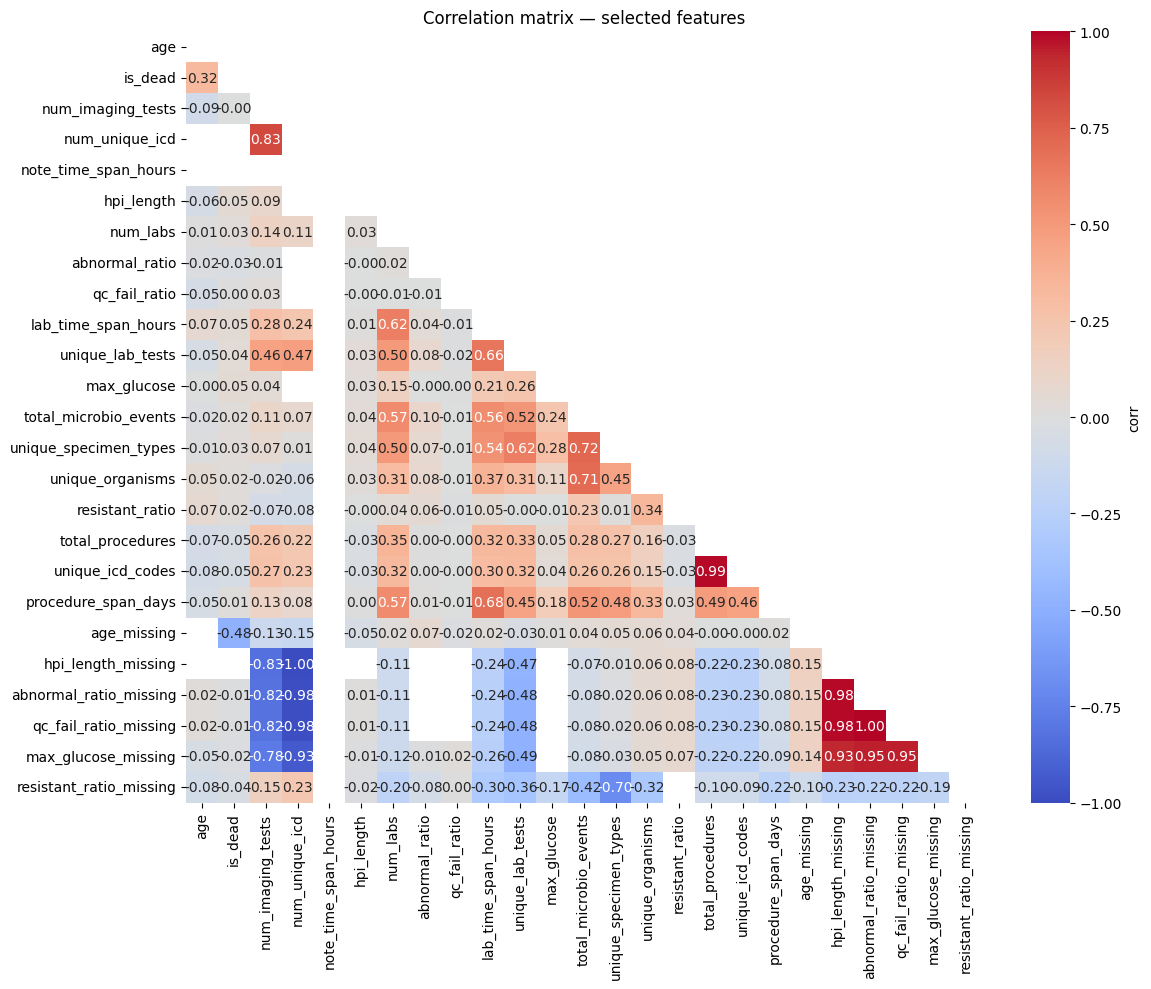

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\selected_features_corr.png
Numeric features used (25): ['age', 'is_dead', 'num_imaging_tests', 'num_unique_icd', 'note_time_span_hours', 'hpi_length', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours', 'unique_lab_tests', 'max_glucose', 'total_microbio_events', 'unique_specimen_types', 'unique_organisms', 'resistant_ratio', 'total_procedures', 'unique_icd_codes', 'procedure_span_days', 'age_missing', 'hpi_length_missing', 'abnormal_ratio_missing', 'qc_fail_ratio_missing', 'max_glucose_missing', 'resistant_ratio_missing']
High-corr pairs (|r| >= 0.8): 15
  num_unique_icd <--> hpi_length_missing  :  -1.000
  abnormal_ratio_missing <--> qc_fail_ratio_missing  :  1.000
  total_procedures <--> unique_icd_codes  :  0.987
  num_unique_icd <--> abnormal_ratio_missing  :  -0.985
  num_unique_icd <--> qc_fail_ratio_missing  :  -0.985
  hpi_length_missing <--> abnormal_ratio_missing 

In [106]:
core_features = [
      'age', 'gender', 'is_dead',
       'num_imaging_tests', 'num_unique_icd', 'note_time_span_hours',
       'hpi_length',
       
        'num_labs', 'abnormal_ratio', 'qc_fail_ratio',
       'lab_time_span_hours', 'unique_lab_tests', 'max_glucose',
       
       'total_microbio_events', 'unique_specimen_types',
       'unique_organisms', 'resistant_ratio', 

       'total_procedures', 'unique_icd_codes', 'procedure_span_days',
       'age_missing', 'hpi_length_missing', 'abnormal_ratio_missing',
       'qc_fail_ratio_missing', 'max_glucose_missing',
       'resistant_ratio_missing'
]

# keep only existing columns
sel = [c for c in core_features if c in patient_profile.columns]
print("Selected features for correlation check:", len(sel), sel)

tmp = patient_profile[sel].copy()

# Encode non-numeric temporarily for correlation
if 'gender' in tmp.columns:
    tmp['gender_enc'] = tmp['gender'].map({'M':1, 'F':0}).fillna(-1)
    tmp = tmp.drop(columns=['gender'])

# Ensure bool/has_ are numeric
for c in tmp.columns:
    if tmp[c].dtype == 'bool':
        tmp[c] = tmp[c].astype(int)

corr_df, high_pairs, used = corr_report(tmp, sel, data_dir=DATA_DIR, threshold=0.80)

So we drop:

Selected features for correlation check: 21 ['age', 'gender', 'is_dead', 'num_imaging_tests', 'note_time_span_hours', 'hpi_length', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours', 'unique_lab_tests', 'max_glucose', 'total_microbio_events', 'unique_specimen_types', 'unique_organisms', 'resistant_ratio', 'total_procedures', 'procedure_span_days', 'age_missing', 'max_glucose_missing', 'resistant_ratio_missing']


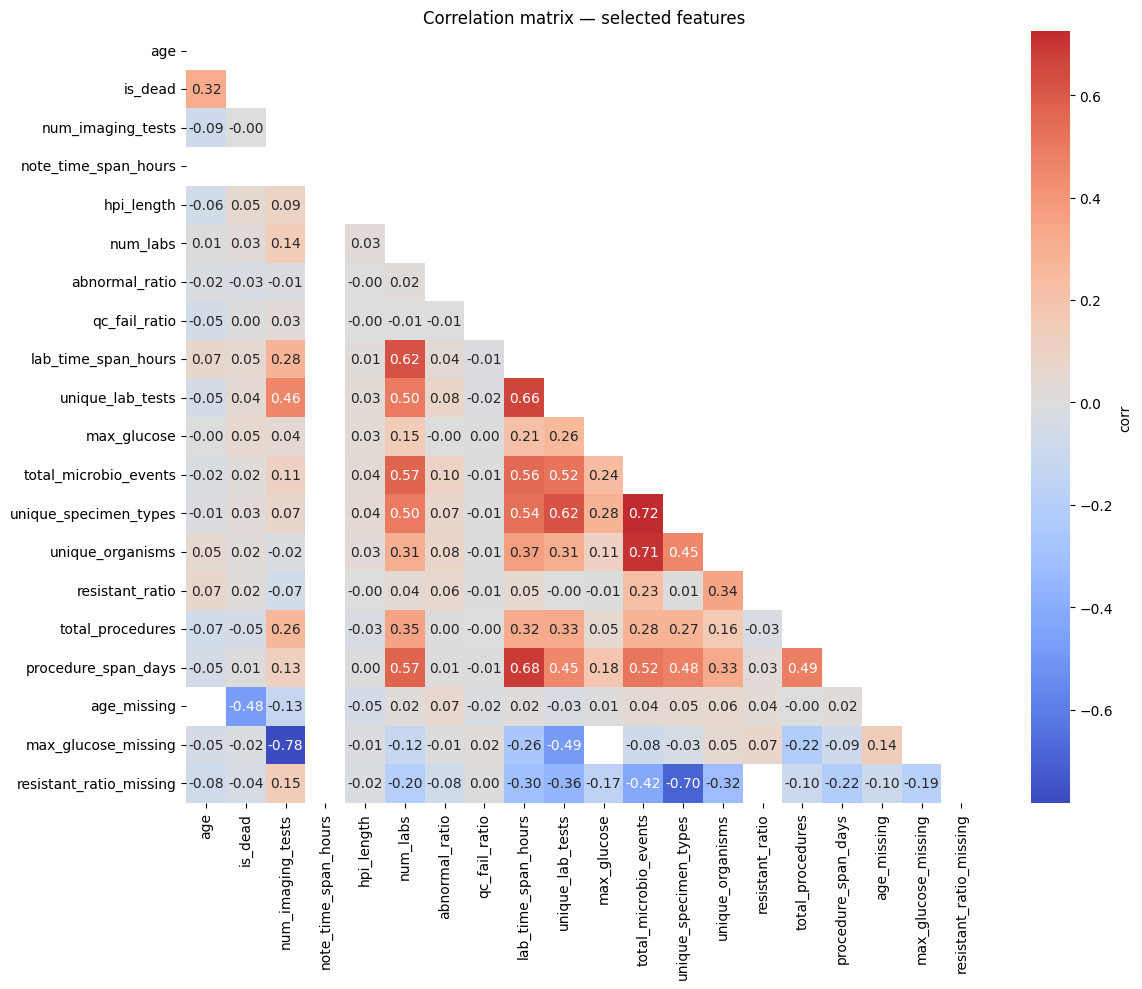

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\selected_features_corr.png
Numeric features used (20): ['age', 'is_dead', 'num_imaging_tests', 'note_time_span_hours', 'hpi_length', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours', 'unique_lab_tests', 'max_glucose', 'total_microbio_events', 'unique_specimen_types', 'unique_organisms', 'resistant_ratio', 'total_procedures', 'procedure_span_days', 'age_missing', 'max_glucose_missing', 'resistant_ratio_missing']
High-corr pairs (|r| >= 0.8): 0


In [107]:
to_drop = [
    # these are highly corr >0.8
    'num_unique_icd', 'qc_fail_ratio_missing', 'unique_icd_codes', 'hpi_length_missing', 'abnormal_ratio_missing'
    # 
]

# keep only existing columns
sel_small = [c for c in sel if c not in to_drop]
print("Selected features for correlation check:", len(sel_small), sel_small)

tmp = patient_profile[sel_small].copy()

# Encode non-numeric temporarily for correlation
if 'gender' in tmp.columns:
    tmp['gender_enc'] = tmp['gender'].map({'M':1, 'F':0}).fillna(-1)
    tmp = tmp.drop(columns=['gender'])

# Ensure bool/has_ are numeric
for c in tmp.columns:
    if tmp[c].dtype == 'bool':
        tmp[c] = tmp[c].astype(int)

corr_df, high_pairs, used = corr_report(tmp, sel_small, data_dir=DATA_DIR, threshold=0.80)

# Further select and compute combined features

Indicators (name — objective — mathematical formulation)

- clinical_activity — Objective: summarize overall care intensity (imaging, labs, micro, procedures).
Formula: clinical_activity = mean( log1p(num_imaging_tests), log1p(num_labs), log1p(total_microbio_events), log1p(total_procedures) )
- lab_abnormality_index — Objective: quantify useful lab abnormality signal adjusted for QC reliability.
Formula: lab_abnormality_index = abnormal_ratio * (1 - qc_fail_ratio) (both treated as proportions; missing → 0)
- micro_resistance_score — Objective: measure microbiology resistance burden weighted by organism/specimen diversity.
Formula: micro_resistance_score = resistant_ratio * log1p(unique_organisms + unique_specimen_types)
- history_depth — Objective: capture documentation richness / diagnostic narrative depth.
Formula: history_depth = log1p(hpi_length) + log1p(note_time_span_hours)
- procedure_density — Objective: intensity of procedures per time span (higher → more interventionist/acute).
Formula: procedure_density = total_procedures / max(1, procedure_span_days)
(1) Metabolic Stress Index (MSI)

Captures global metabolic derangement.

MSI
=
𝑧
(
Glucose
)
+
𝑧
(
Lactate
)
+
𝑧
(
Anion Gap
)
+
𝑧
(
Bicarbonate
)
⋅
(
−
1
)
MSI=z(Glucose)+z(Lactate)+z(Anion Gap)+z(Bicarbonate)⋅(−1)

Required variables:
Glucose, Lactate, Anion Gap, Bicarbonate (or Calculated Total CO2)

(2) Renal Injury Score (RIS)

Integrates renal clearance + nitrogen load + electrolytes.

RIS
=
𝑧
(
Creatinine
)
+
𝑧
(
Urea Nitrogen
)
+
𝑧
(
Phosphate
)
+
𝑧
(
Potassium
)
RIS=z(Creatinine)+z(Urea Nitrogen)+z(Phosphate)+z(Potassium)

Required:
Creatinine, Urea Nitrogen, Phosphate, Potassium

(3) Oxygenation Dysfunction Index (ODI)

Captures respiratory/metabolic compromise.

ODI
=
𝑧
(
pO2
)
⋅
(
−
1
)
+
𝑧
(
pCO2
)
+
𝑧
(
pH
)
⋅
(
−
1
)
+
𝑧
(
Base Excess
)
⋅
(
−
1
)
ODI=z(pO2)⋅(−1)+z(pCO2)+z(pH)⋅(−1)+z(Base Excess)⋅(−1)

Required:
pO2, pCO2, pH, Base Excess

(4) Inflammation–Liver Stress Index (ILSI)

Captures systemic inflammation and hepatic involvement.

ILSI
=
𝑧
(
CRP
)
+
𝑧
(
AST
)
+
𝑧
(
ALT
)
+
𝑧
(
LD
)
ILSI=z(CRP)+z(AST)+z(ALT)+z(LD)

Required:
C-Reactive Protein, Asparate Aminotransferase (AST),
Alanine Aminotransferase (ALT), Lactate Dehydrogenase (LD)

(5) Hematologic Stability Score (HSS)

Captures marrow response + oxygen-carrying capacity.

HSS
=
𝑧
(
Hemoglobin
)
+
𝑧
(
Hematocrit
)
+
𝑧
(
RBC
)
+
𝑧
(
RDW
)
⋅
(
−
1
)
HSS=z(Hemoglobin)+z(Hematocrit)+z(RBC)+z(RDW)⋅(−1)

Required:
Hemoglobin, Hematocrit, Red Blood Cells, RDW

In [177]:
def compute_indicators_and_run_corr(df, data_dir=None, save_plots=True, corr_threshold=0.60, figsize=(10,8)):
    """
    Compute the team indicators (including MSI, RIS, ODI, ILSI, HSS) using available max-* labs,
    add them to a copy of df, then produce correlation matrices for:
      1) indicators only
      2) indicators + all original 'core' features (if present)
      3) indicators + small old feature set ['age','n_total_admissions','is_dead','gender']
    Returns: (df_out, corr_results)
    """
    d = df.copy()   #'num_imaging_tests', 'num_labs', 'total_microbio_events', 'n_total_admissions'

    # --- safe fills for counts / spans (absence -> 0) ---
    counts = ['num_imaging_tests', 'num_labs', 'total_microbio_events', 'total_procedures']
    for c in counts:
        if c in d.columns:
            d[c] = d[c].fillna(0)

    # --- original 5 indicators ---
    cols_for_activity = [c for c in counts if c in d.columns]
    if cols_for_activity:
        # clinical_activity = mean(log1p(counts...))
        d['clinical_activity'] = np.mean([np.log1p(d[c]) for c in cols_for_activity], axis=0)

    if 'resistant_ratio' in d.columns:
        # micro_resistance_score = resistant_ratio * log1p(unique_organisms + unique_specimen_types)
        rr = d['resistant_ratio'].fillna(0)
        uo = d['unique_organisms'].fillna(0) if 'unique_organisms' in d.columns else 0
        us = d['unique_specimen_types'].fillna(0) if 'unique_specimen_types' in d.columns else 0
        d['micro_resistance_score'] = rr * np.log1p(uo + us)

    hl = d['hpi_length'].fillna(0) if 'hpi_length' in d.columns else 0
    nts = d['note_time_span_hours'].fillna(0) if 'note_time_span_hours' in d.columns else 0
    # history_depth = log1p(hpi_length) + log1p(note_time_span_hours)
    d['history_depth'] = np.log1p(hl) + np.log1p(nts)

    if 'total_procedures' in d.columns:
        # procedure_density = total_procedures / max(1, procedure_span_days)
        pdays = d['procedure_span_days'].fillna(1) if 'procedure_span_days' in d.columns else 1
        d['procedure_density'] = d['total_procedures'] / pdays.clip(lower=1)

    # --- additional indicators ---
    if 'n_diagnoses' in d.columns:
        d['diagnosis_burden'] = np.log1p(d['n_diagnoses'].fillna(0))

    # --- metabolic_stress_index and other composite lab indices (MSI, RIS, ODI, ILSI, HSS) ---
    # Helper: choose preferred column among candidates (prefer max_ then mean_ then raw)
    def first_existing(col_candidates):
        for c in col_candidates:
            if c in d.columns:
                return c
        return None

    # robust z-like scaling that uses median/IQR (safe with NaNs)
    def robust_z_series(s):
        s = pd.to_numeric(s, errors='coerce')
        med = s.median()
        iqr = s.quantile(0.75) - s.quantile(0.25)
        denom = iqr if iqr > 0 else (s.std() if s.std() > 0 else 1.0)
        return (s.fillna(med) - med) / (denom + 1e-9)

    # analyte -> candidate column names (extend if needed)
    analyte_candidates = {
        'glucose': ['max_glucose', 'mean_glucose', 'glucose'],
        'lactate': ['max_lactate', 'mean_lactate', 'lactate'],
        'anion_gap': ['max_anion_gap', 'mean_anion_gap', 'anion_gap', 'anion gap'],
        'bicarbonate': ['max_bicarbonate', 'mean_bicarbonate', 'calculated_total_co2', 'calculated total co2', 'total_co2', 'bicarbonate'],
        'creatinine': ['max_creatinine', 'mean_creatinine', 'creatinine'],
        'urea_nitrogen': ['max_urea_nitrogen', 'mean_urea_nitrogen', 'urea_nitrogen', 'bun'],
        'phosphate': ['max_phosphate', 'mean_phosphate', 'phosphate'],
        'potassium': ['max_potassium', 'mean_potassium', 'potassium', 'k'],
        'pO2': ['max_pO2', 'max_po2', 'pO2', 'po2', 'pao2'],
        'pCO2': ['max_pCO2', 'max_pco2', 'pCO2', 'pco2', 'paco2'],
        'pH': ['max_pH', 'max_ph', 'pH', 'ph'],
        'base_excess': ['max_base excess', 'base excess', 'be'],
        'crp': ['max_crp', 'crp', 'c-reactive protein', 'c reactive protein'],
        'ast': ['max_ast', 'ast'],
        'alt': ['max_alt', 'alt'],
        'ld': ['max_ld', 'ld', 'ldh'],
        'hemoglobin': ['min_hemoglobin', 'max_hemoglobin', 'mean_hemoglobin', 'hemoglobin', 'hb'],
        'hematocrit': ['min_hematocrit', 'max_hematocrit', 'hematocrit', 'hct'],
        'rbc': ['max_rbc', 'mean_rbc', 'rbc', 'red_blood_cells', 'red blood cells'],
        'rdw': ['max_rdw', 'mean_rdw', 'rdw']
    }

    # prepare z-series for analytes (fill zeros when missing so formulas still produce numeric outputs)
    z = {}
    for analyte, candidates in analyte_candidates.items():
        col = first_existing(candidates)
        if col is not None:
            z[analyte] = robust_z_series(d[col])
        else:
            # no data available -> zero series (neutral)
            z[analyte] = pd.Series(0.0, index=d.index)

    # Metabolic Stress Index (MSI)
    # MSI = z(Glucose) + z(Lactate) + z(Anion Gap) - z(Bicarbonate)
    # Higher MSI -> greater metabolic derangement (glucose/lactate/AG up, bicarb down)
    d['metabolic_stress_index'] = z['glucose'] + z['lactate'] + z['anion_gap'] - z['bicarbonate']

    # Renal Injury Score (RIS)
    # RIS = z(Creatinine) + z(Urea Nitrogen) + z(Phosphate) + z(Potassium)
    # Higher RIS -> more renal dysfunction / electrolyte disturbance
    d['renal_injury_score'] = z['creatinine'] + z['urea_nitrogen'] + z['phosphate'] + z['potassium']

    # Oxygenation Dysfunction Index (ODI)
    # ODI = -z(pO2) + z(pCO2) - z(pH) - z(Base Excess)
    # Low pO2, acidosis (low pH), negative base excess increase ODI; high pCO2 increases ODI
    d['oxygenation_dysfunction_index'] = -z['pO2'] + z['pCO2'] - z['pH'] - z['base_excess']

    # Inflammation–Liver Stress Index (ILSI)
    # ILSI = z(CRP) + z(AST) + z(ALT) + z(LD)
    # Captures systemic inflammation and hepatic injury signal
    d['inflammation_liver_stress_index'] = z['crp'] + z['ast'] + z['alt'] + z['ld']

    # Hematologic Stability Score (HSS)
    # HSS = z(Hemoglobin) + z(Hematocrit) + z(RBC) - z(RDW)
    # Higher HSS -> more stable hematology (higher Hb/Hct/RBC and lower RDW desirable)
    d['hematologic_stability_score'] = z['hemoglobin'] + z['hematocrit'] + z['rbc'] - z['rdw']

    # Availability flags for key analytes (helpful downstream)
    for key, candidates in analyte_candidates.items():
        d[f'has_{key}'] = int(any(c in d.columns for c in candidates))

    # recent admission recency score
    if 'days_since_last_admission' in d.columns:
        d['recent_admission_score'] = 1.0 / (1.0 + d['days_since_last_admission'].fillna(3650))

    # list of computed indicators that exist now
    indicators = [c for c in [
        'clinical_activity','lab_abnormality_index','micro_resistance_score',
        'history_depth','procedure_density',
        'diagnosis_burden','metabolic_stress_index','recent_admission_score',
        'renal_injury_score','oxygenation_dysfunction_index',
        'inflammation_liver_stress_index','hematologic_stability_score'
    ] if c in d.columns]

    print("Computed indicators:", indicators)

    # --- prepare old/core features ---
    creat_col = None
    if 'max_creatinine' in d.columns:
        creat_col = 'max_creatinine'
    elif 'mean_creatinine' in d.columns:
        creat_col = 'mean_creatinine'

    core_features_local = [
        'age','gender','is_dead',
        'num_imaging_tests','note_time_span_hours','hpi_length',
        'num_labs','abnormal_ratio','qc_fail_ratio','lab_time_span_hours','unique_lab_tests','max_glucose',
        'total_microbio_events','unique_specimen_types','unique_organisms','resistant_ratio',
        'total_procedures','procedure_span_days','n_diagnoses', creat_col, 'days_since_last_admission','n_total_admissions'
    ]
    # keep only existing
    old_all = [c for c in core_features_local if c in d.columns]

    small_old = [c for c in ['num_unique_icd', 'age','n_total_admissions','is_dead','gender', 'abnormal_ratio', 'qc_fail_ratio', 'num_imaging_tests', 'num_labs', 'total_microbio_events', 'n_total_admissions'] if c in d.columns]

    # where to save plots
    save_dir = os.path.abspath('.') if data_dir is None else data_dir
    plots_dir = os.path.join(save_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)

    corr_results = {}

    # 1) indicators only
    name = 'indicators_only'
    print(f"\nRunning correlation: {name}")
    corr_results[name] = corr_report(d, indicators, data_dir=save_dir, plot_name=f'{name}_corr.png',
                                    threshold=corr_threshold, figsize=figsize, show_plot=save_plots)

    # 2) indicators + all old/core features
    name = 'indicators_plus_old_all'
    features_combo = indicators + old_all
    features_combo = [c for c in features_combo if c in d.columns]
    if len(features_combo) >= 2:
        print(f"\nRunning correlation: {name} (n_features={len(features_combo)})")
        corr_results[name] = corr_report(d, features_combo, data_dir=save_dir, plot_name=f'{name}_corr.png',
                                        threshold=corr_threshold, figsize=figsize, show_plot=save_plots)
    else:
        corr_results[name] = (None, [], [])

    # 3) indicators + small_old (user requested)
    name = 'indicators_plus_small_old'
    features_combo2 = indicators + small_old
    features_combo2 = [c for c in features_combo2 if c in d.columns]
    if len(features_combo2) >= 2:
        print(f"\nRunning correlation: {name} (n_features={len(features_combo2)})")
        corr_results[name] = corr_report(d, features_combo2, data_dir=save_dir, plot_name=f'{name}_corr.png',
                                        threshold=corr_threshold, figsize=figsize, show_plot=save_plots)
    else:
        corr_results[name] = (None, [], [])

    return d, corr_results

Computed indicators: ['clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index', 'renal_injury_score', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score']

Running correlation: indicators_only


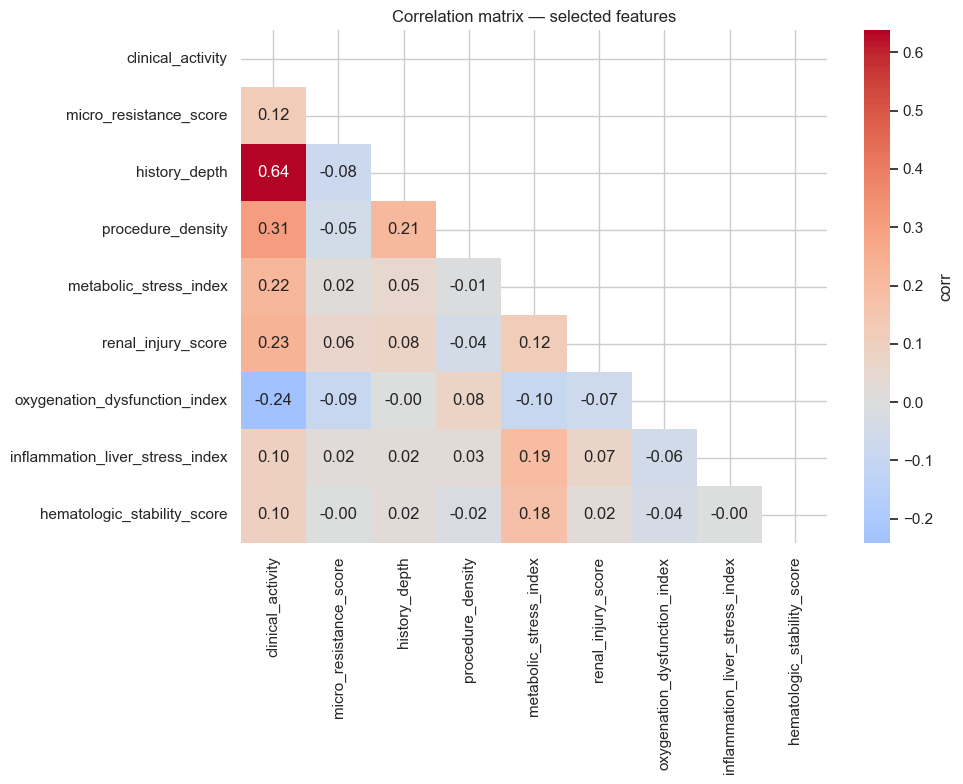

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\indicators_only_corr.png
Numeric features used (9): ['clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index', 'renal_injury_score', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score']
High-corr pairs (|r| >= 0.6): 1
  clinical_activity <--> history_depth  :  0.638

Running correlation: indicators_plus_old_all (n_features=28)


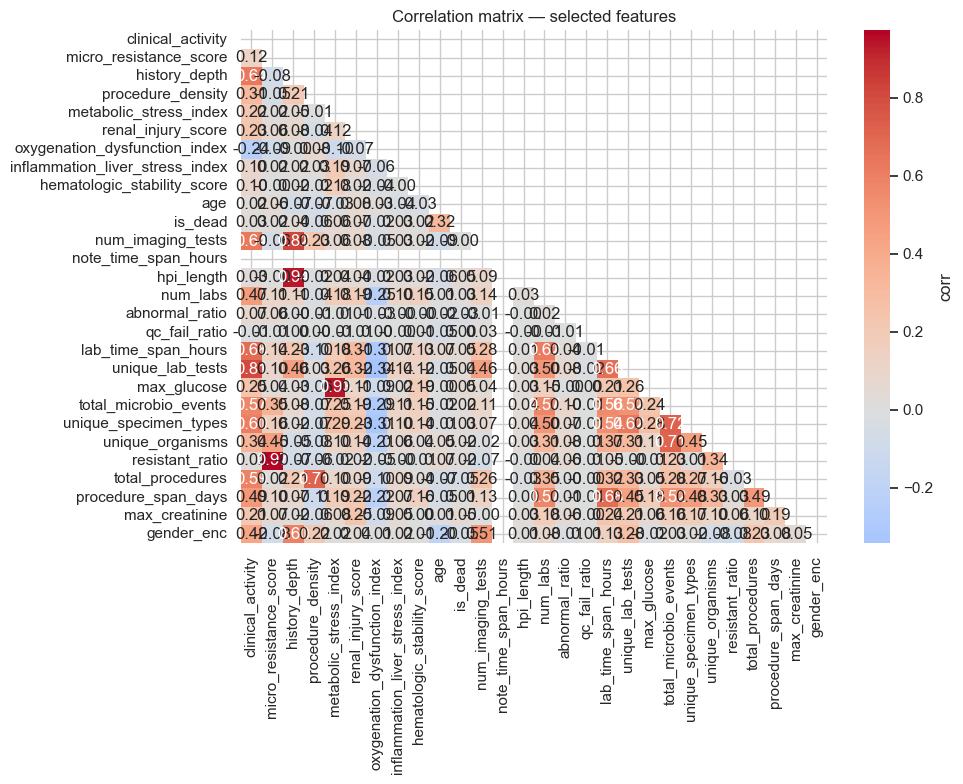

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\indicators_plus_old_all_corr.png
Numeric features used (28): ['clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index', 'renal_injury_score', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'age', 'is_dead', 'num_imaging_tests', 'note_time_span_hours', 'hpi_length', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours', 'unique_lab_tests', 'max_glucose', 'total_microbio_events', 'unique_specimen_types', 'unique_organisms', 'resistant_ratio', 'total_procedures', 'procedure_span_days', 'max_creatinine', 'gender_enc']
High-corr pairs (|r| >= 0.6): 15
  micro_resistance_score <--> resistant_ratio  :  0.973
  history_depth <--> hpi_length  :  0.938
  metabolic_stress_index <--> max_glucose  :  0.934
  history_depth <--> num_imaging_tests  :  0.822
  clinical_activity <--> unique_

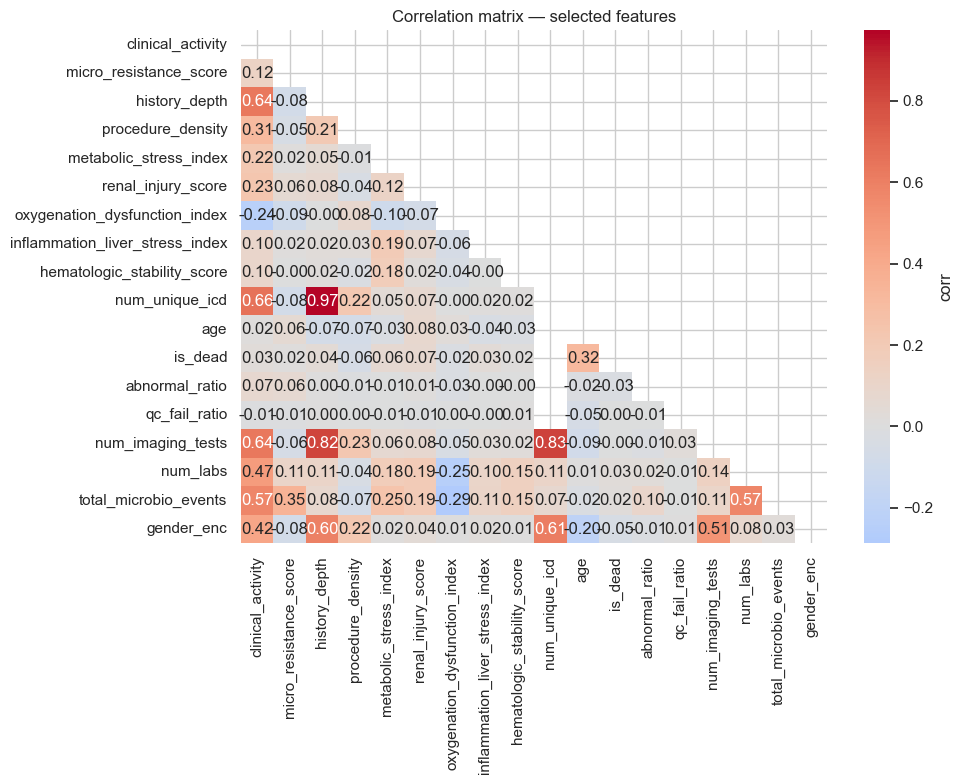

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\indicators_plus_small_old_corr.png
Numeric features used (18): ['clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index', 'renal_injury_score', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'num_unique_icd', 'age', 'is_dead', 'abnormal_ratio', 'qc_fail_ratio', 'num_imaging_tests', 'num_labs', 'total_microbio_events', 'gender_enc']
High-corr pairs (|r| >= 0.6): 7
  history_depth <--> num_unique_icd  :  0.973
  num_unique_icd <--> num_imaging_tests  :  0.833
  history_depth <--> num_imaging_tests  :  0.822
  clinical_activity <--> num_unique_icd  :  0.655
  clinical_activity <--> history_depth  :  0.638
  clinical_activity <--> num_imaging_tests  :  0.637
  num_unique_icd <--> gender_enc  :  0.611


In [178]:
patient_profile_new, corr_res = compute_indicators_and_run_corr(patient_profile, data_dir=DATA_DIR, save_plots=True)

In [163]:
patient_profile_new.describe()

,subject_id,hadm_id,has_heartnotes,age,is_dead,num_imaging_tests,num_unique_icd,note_time_span_hours,hpi_length,num_labs,...,has_pH,has_base_excess,has_crp,has_ast,has_alt,has_ld,has_hemoglobin,has_hematocrit,has_rbc,has_rdw
count,5.166000e+03,5.166000e+03,5166.000000,1363.000000,4864.000000,5166.000000,5166.000000,5166.0,4864.000000,5166.000000,...,5166.0,5166.0,5166.0,5166.0,5166.0,5166.0,5166.0,5166.0,5166.0,5166.0
mean,1.539306e+07,2.501832e+07,0.941541,68.978723,0.081826,3.104336,0.941541,0.0,1728.680715,226.015292,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,3.073751e+06,2.871364e+06,0.234632,14.973358,0.274127,0.928495,0.234632,0.0,676.873262,500.862472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000098e+07,2.000446e+07,0.000000,18.000000,0.000000,0.000000,0.000000,0.0,21.000000,0.000000,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.267767e+07,2.261127e+07,1.000000,60.000000,0.000000,3.000000,1.000000,0.0,1281.000000,69.000000,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,1.539807e+07,2.502269e+07,1.000000,70.000000,0.000000,3.000000,1.000000,0.0,1667.000000,126.000000,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,1.812905e+07,2.746995e+07,1.000000,81.000000,0.000000,4.000000,1.000000,0.0,2099.500000,247.000000,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,1.999860e+07,2.999967e+07,1.000000,95.000000,1.000000,6.000000,1.000000,0.0,9085.000000,22580.000000,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Encode gender

In [164]:
patient_profile_new["gender"].value_counts(dropna=False)

gender
M      2841
F      2017
NaN     308
Name: count, dtype: int64

In [165]:
if 'patient_profile_new' in globals() and 'gender' in patient_profile_new.columns:
    g2 = patient_profile_new['gender'].astype(str).str.strip().str.upper()
    patient_profile_new['gender_enc'] = g2.map({'M': 1, 'F': 0}).fillna(-1).astype(int)

In [166]:
patient_profile_new["gender_enc"].value_counts(dropna=False)

gender_enc
 1    2841
 0    2017
-1     308
Name: count, dtype: int64

# Take only comuted indicators + some more (based on corr)  & Save to csv

In [167]:
# Build patient_profile_small = subject_id + hadm_id + newly created indicators (exclude has_*) + requested extras
orig_cols = set(patient_profile.columns)
new_cols = [c for c in patient_profile_new.columns if c not in orig_cols]

# exclude any has_ columns
new_indicator_cols = [c for c in new_cols if not c.startswith('has_')]

# extras: NOTE no num_imaging_tests bc high corr with history_depth 
extras = ['age','n_total_admissions','is_dead','gender_enc', 'abnormal_ratio', 'qc_fail_ratio', 'num_labs', 'total_microbio_events', 'n_total_admissions']
extras_present = [c for c in extras if c in patient_profile_new.columns]

# final ordered, unique list (defensive: keep only columns that actually exist)
final_cols = ['subject_id', 'hadm_id'] + sorted(new_indicator_cols) + extras_present
final_cols = [c for i, c in enumerate(final_cols) if c in patient_profile_new.columns and c not in final_cols[:i]]

patient_profile_small = patient_profile_new[final_cols].copy()

print(f"Columns saved ({len(patient_profile_small.columns)}):")
print(patient_profile_small.columns.tolist())
print(f"Rows: {len(patient_profile_small):,}")
patient_profile_small.describe()

Columns saved (18):
['subject_id', 'hadm_id', 'clinical_activity', 'gender_enc', 'hematologic_stability_score', 'history_depth', 'inflammation_liver_stress_index', 'metabolic_stress_index', 'micro_resistance_score', 'oxygenation_dysfunction_index', 'procedure_density', 'renal_injury_score', 'age', 'is_dead', 'abnormal_ratio', 'qc_fail_ratio', 'num_labs', 'total_microbio_events']
Rows: 5,166


,subject_id,hadm_id,clinical_activity,gender_enc,hematologic_stability_score,history_depth,inflammation_liver_stress_index,metabolic_stress_index,micro_resistance_score,oxygenation_dysfunction_index,procedure_density,renal_injury_score,age,is_dead,abnormal_ratio,qc_fail_ratio,num_labs,total_microbio_events
count,5.166000e+03,5.166000e+03,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000,1363.000000,4864.000000,4855.000000,4855.000000,5166.000000,5166.000000
mean,1.539306e+07,2.501832e+07,1.961426,0.490321,283.016496,6.943835,2.484855,1.146636,0.016946,-0.019103,2.057535,5.927326,68.978723,0.081826,0.000086,0.020154,226.015292,3.017034
std,3.073751e+06,2.871364e+06,0.679923,0.607634,4643.720614,1.778370,34.734589,6.165067,0.095124,1.315734,2.370711,21.596305,14.973358,0.274127,0.000800,0.014587,500.862472,6.744378
min,1.000098e+07,2.000446e+07,0.173287,-1.000000,-4.901199,0.000000,-1.720090,-4.202460,0.000000,-44.200562,0.000000,-4.861111,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.267767e+07,2.261127e+07,1.640611,0.000000,-1.302816,7.080237,-0.312406,-0.446809,0.000000,-0.283346,0.000000,-0.738636,60.000000,0.000000,0.000000,0.011236,69.000000,0.000000
50%,1.539807e+07,2.502269e+07,1.958004,1.000000,-0.348078,7.388328,0.000000,0.020213,0.000000,0.000000,1.000000,0.000000,70.000000,0.000000,0.000000,0.019002,126.000000,1.000000
75%,1.812905e+07,2.746995e+07,2.336524,1.000000,0.464641,7.635666,0.000000,0.824140,0.000000,0.713454,3.000000,1.809975,81.000000,0.000000,0.000000,0.027141,247.000000,3.000000
max,1.999860e+07,2.999967e+07,4.756737,1.000000,147736.168325,9.114490,1960.863790,226.915334,1.098612,4.043924,14.000000,468.235495,95.000000,1.000000,0.019802,0.285714,22580.000000,122.000000


In [168]:
patient_profile_small.to_csv(os.path.join(DATA_DIR, "patient_profile_small.csv"), index=False)

In [169]:
patient_profile_small

,subject_id,hadm_id,clinical_activity,gender_enc,hematologic_stability_score,history_depth,inflammation_liver_stress_index,metabolic_stress_index,micro_resistance_score,oxygenation_dysfunction_index,procedure_density,renal_injury_score,age,is_dead,abnormal_ratio,qc_fail_ratio,num_labs,total_microbio_events
0,10000980,26913865,2.375005,0,-1.580146,6.965080,-0.680743,0.948936,0.0,-0.145857,7.000000,1.915404,75.0,1.0,0.0,0.024096,166.0,1.0
1,10000980,29654838,1.370160,0,-1.009657,6.647688,-1.206081,0.482979,0.0,0.708820,0.000000,1.188131,75.0,1.0,0.0,0.000000,59.0,0.0
2,10002013,24760295,1.659969,0,0.514990,7.604894,0.000000,2.817021,0.0,0.715771,2.000000,-2.017677,NaN,0.0,0.0,0.000000,50.0,0.0
3,10002155,23822395,3.033730,0,-0.413521,7.469084,0.000000,-0.095745,0.0,-0.455848,0.571429,2.340909,NaN,0.0,0.0,0.030227,397.0,12.0
4,10004457,28723315,1.161098,1,1.473653,7.486613,-0.667314,-1.406383,0.0,0.717315,0.000000,-0.506313,66.0,0.0,0.0,0.040000,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5161,19998596,24860241,1.637770,0,-2.087773,8.017308,-0.430743,-0.871844,0.0,-0.274977,0.000000,39.184343,NaN,0.0,0.0,0.000000,174.0,0.0
5162,19998597,23720781,1.697243,0,181.893465,7.368970,-0.441656,19.300839,0.0,-1.135774,0.000000,-0.767677,NaN,0.0,0.0,0.018100,221.0,0.0
5163,19998598,26940500,1.382357,0,-1.147743,7.163947,49.740134,2.771544,0.0,-1.135774,0.000000,-2.234848,NaN,0.0,0.0,0.032258,62.0,0.0
5164,19998599,20343031,1.412244,1,-0.678473,7.015712,0.000000,1.942553,0.0,0.718474,0.000000,-2.112374,NaN,0.0,0.0,0.000000,70.0,0.0


# FInal DU of patient prfile small

In [170]:
patient_profile_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject_id                       5166 non-null   int64  
 1   hadm_id                          5166 non-null   int64  
 2   clinical_activity                5166 non-null   float64
 3   gender_enc                       5166 non-null   int64  
 4   hematologic_stability_score      5166 non-null   float64
 5   history_depth                    5166 non-null   float64
 6   inflammation_liver_stress_index  5166 non-null   float64
 7   metabolic_stress_index           5166 non-null   float64
 8   micro_resistance_score           5166 non-null   float64
 9   oxygenation_dysfunction_index    5166 non-null   float64
 10  procedure_density                5166 non-null   float64
 11  renal_injury_score               5166 non-null   float64
 12  age                 

In [171]:
patient_profile_small.describe()

,subject_id,hadm_id,clinical_activity,gender_enc,hematologic_stability_score,history_depth,inflammation_liver_stress_index,metabolic_stress_index,micro_resistance_score,oxygenation_dysfunction_index,procedure_density,renal_injury_score,age,is_dead,abnormal_ratio,qc_fail_ratio,num_labs,total_microbio_events
count,5.166000e+03,5.166000e+03,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000,1363.000000,4864.000000,4855.000000,4855.000000,5166.000000,5166.000000
mean,1.539306e+07,2.501832e+07,1.961426,0.490321,283.016496,6.943835,2.484855,1.146636,0.016946,-0.019103,2.057535,5.927326,68.978723,0.081826,0.000086,0.020154,226.015292,3.017034
std,3.073751e+06,2.871364e+06,0.679923,0.607634,4643.720614,1.778370,34.734589,6.165067,0.095124,1.315734,2.370711,21.596305,14.973358,0.274127,0.000800,0.014587,500.862472,6.744378
min,1.000098e+07,2.000446e+07,0.173287,-1.000000,-4.901199,0.000000,-1.720090,-4.202460,0.000000,-44.200562,0.000000,-4.861111,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.267767e+07,2.261127e+07,1.640611,0.000000,-1.302816,7.080237,-0.312406,-0.446809,0.000000,-0.283346,0.000000,-0.738636,60.000000,0.000000,0.000000,0.011236,69.000000,0.000000
50%,1.539807e+07,2.502269e+07,1.958004,1.000000,-0.348078,7.388328,0.000000,0.020213,0.000000,0.000000,1.000000,0.000000,70.000000,0.000000,0.000000,0.019002,126.000000,1.000000
75%,1.812905e+07,2.746995e+07,2.336524,1.000000,0.464641,7.635666,0.000000,0.824140,0.000000,0.713454,3.000000,1.809975,81.000000,0.000000,0.000000,0.027141,247.000000,3.000000
max,1.999860e+07,2.999967e+07,4.756737,1.000000,147736.168325,9.114490,1960.863790,226.915334,1.098612,4.043924,14.000000,468.235495,95.000000,1.000000,0.019802,0.285714,22580.000000,122.000000


Distribution of clinical_activity: std=0.680, mean=1.961
Distribution of gender_enc: std=0.608, mean=0.490
Distribution of hematologic_stability_score: std=4643.721, mean=283.016
Distribution of history_depth: std=1.778, mean=6.944
Distribution of inflammation_liver_stress_index: std=34.735, mean=2.485
Distribution of metabolic_stress_index: std=6.165, mean=1.147
Distribution of micro_resistance_score: std=0.095, mean=0.017
Distribution of oxygenation_dysfunction_index: std=1.316, mean=-0.019
Distribution of procedure_density: std=2.371, mean=2.058
Distribution of renal_injury_score: std=21.596, mean=5.927
Distribution of age: std=14.973, mean=68.979
Distribution of is_dead: std=0.274, mean=0.082
Distribution of abnormal_ratio: std=0.001, mean=0.000
Distribution of qc_fail_ratio: std=0.015, mean=0.020
Distribution of num_labs: std=500.862, mean=226.015
Distribution of total_microbio_events: std=6.744, mean=3.017
Boxplots saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health

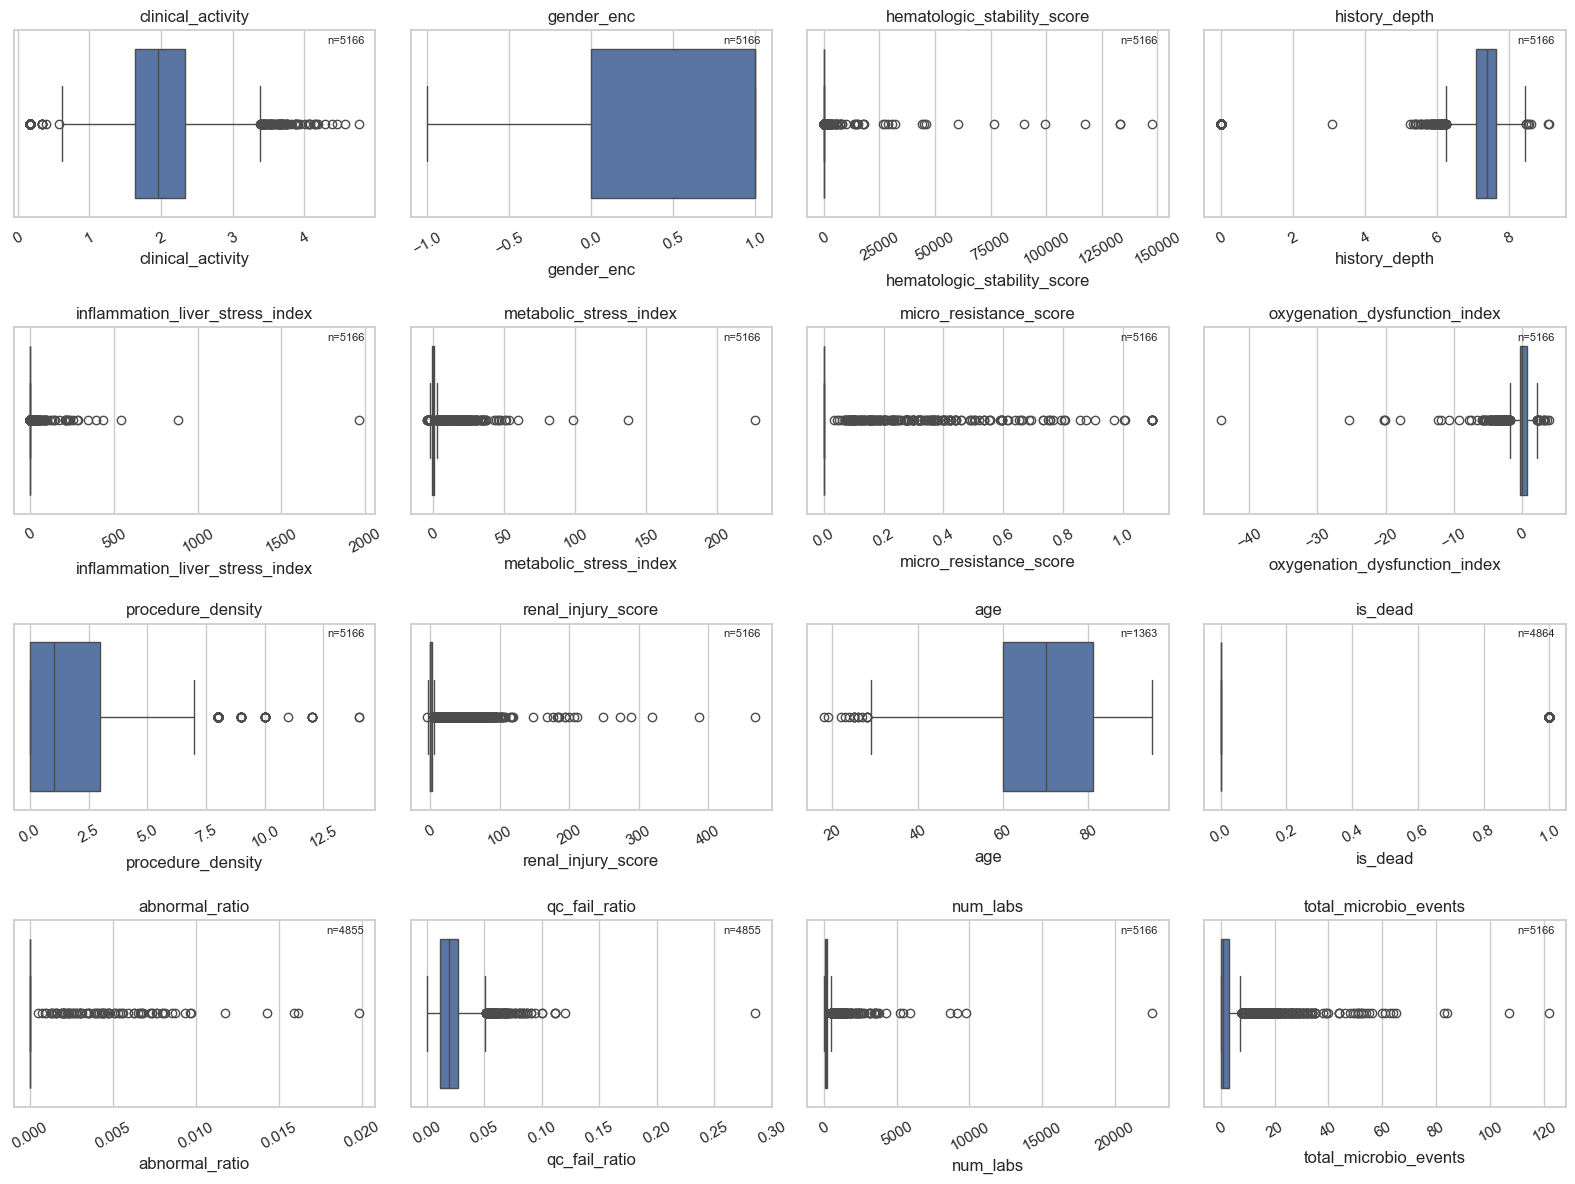

In [173]:
# Boxplots for all numeric columns in patient_profile_small (exclude ids)
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

num_cols = [c for c in patient_profile_small.select_dtypes(include=[np.number]).columns
            if c not in ('subject_id', 'hadm_id')]
if not num_cols:
    print("No numeric columns found for boxplots.")
else:
    cols_per_row = 4
    n = len(num_cols)
    rows = math.ceil(n / cols_per_row)
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 4, rows * 3))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(num_cols):
        print(f"Distribution of {col}: std={patient_profile_small[col].std():.3f}, mean={patient_profile_small[col].mean():.3f}")
        ax = axes[i]
        # avoid plotting infinite values
        series = patient_profile_small[col].replace([np.inf, -np.inf], np.nan).dropna()
        if series.empty:
            ax.text(0.5, 0.5, "no data", ha='center', va='center')
            ax.set_title(col)
            continue
        sns.boxplot(x=series, ax=ax, color='C0')
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=30)
        ax.text(0.97, 0.97, f"n={len(series)}", transform=ax.transAxes,
                ha='right', va='top', fontsize=8)

    # turn off any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    os.makedirs(os.path.join(DATA_DIR, 'plots'), exist_ok=True)
    out_path = os.path.join(DATA_DIR, 'plots', 'patient_profile_small_boxplots_grid.png')
    plt.savefig(out_path, dpi=200, bbox_inches='tight')
    print(f"Boxplots saved to: {out_path}")
    plt.show()

- hematologic_stability_score very high std > 4000 :
- num_labs: std 500

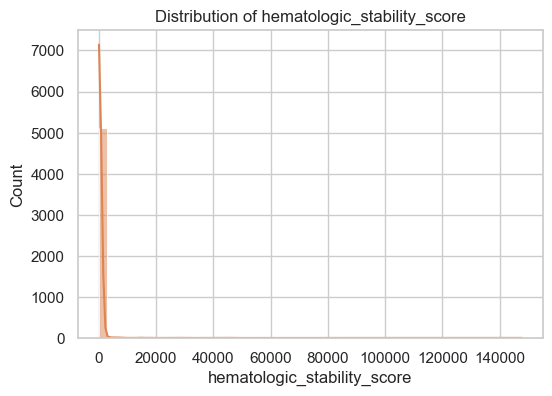

In [174]:
# inspeect hematologic_stability_score distribution
col = 'hematologic_stability_score'
series = patient_profile_small[col].replace([np.inf, -np.inf], np.nan).dropna()
plt.figure(figsize=(6,4))
sns.histplot(series, bins=50, kde=True, color='C1')
plt.title(f'Distribution of {col}')
plt.xlabel(col)
plt.ylabel('Count')
plt.show()


In [179]:
# Inspect components of hematologic_stability_score (Hb, Hct, RBC, RDW) and recompute HSS

# choose dataframe with computed indicators
df = patient_profile_new if 'patient_profile_new' in globals() else patient_profile_small

candidates_map = {
    'hemoglobin': ['min_hemoglobin', 'max_hemoglobin', 'mean_hemoglobin', 'hemoglobin', 'hb'],
    'hematocrit': ['min_hematocrit', 'max_hematocrit', 'hematocrit', 'hct'],
    'rbc': ['max_rbc', 'mean_rbc', 'rbc', 'red_blood_cells', 'red blood cells'],
    'rdw': ['max_rdw', 'mean_rdw', 'rdw']
}

def first_existing(col_list, df):
    for c in col_list:
        if c in df.columns:
            return c
    return None

rows_info = []
raw_series = {}
for analyte, cand in candidates_map.items():
    col = first_existing(cand, df)
    if col is None:
        rows_info.append({'analyte': analyte, 'column': None, 'n_non_na': 0})
        raw_series[analyte] = pd.Series(np.nan, index=df.index)
        continue
    s = pd.to_numeric(df[col], errors='coerce').replace([np.inf, -np.inf], np.nan)
    raw_series[analyte] = s
    s_non = s.dropna()
    if s_non.empty:
        rows_info.append({'analyte': analyte, 'column': col, 'n_non_na': 0})
        continue

    q1 = s_non.quantile(0.25); q3 = s_non.quantile(0.75); iqr = q3 - q1
    median = s_non.median(); mean = s_non.mean(); std = s_non.std(ddof=0)
    pctiles = s_non.quantile([0.01,0.05,0.25,0.5,0.75,0.95,0.99]).to_dict()
    n_gt_mean_3std = ((s_non - mean) / (std if std>0 else 1e-9) > 3).sum()
    n_gt_mean_5std = ((s_non - mean) / (std if std>0 else 1e-9) > 5).sum()

    rows_info.append({
        'analyte': analyte,
        'column': col,
        'n_non_na': int(len(s_non)),
        'mean': float(mean),
        'std': float(std),
        'median': float(median),
        'iqr': float(iqr),
        'min': float(s_non.min()),
        'max': float(s_non.max()),
        'p01': float(pctiles.get(0.01, np.nan)),
        'p05': float(pctiles.get(0.05, np.nan)),
        'p50': float(pctiles.get(0.5, np.nan)),
        'p95': float(pctiles.get(0.95, np.nan)),
        'p99': float(pctiles.get(0.99, np.nan)),
        'n>mean+3std': int(n_gt_mean_3std),
        'n>mean+5std': int(n_gt_mean_5std)
    })

summary_df = pd.DataFrame(rows_info).set_index('analyte')
print("Per-analyte summary (chosen columns):")
display(summary_df)

# Recreate robust-z exactly like compute_indicators
def robust_z_series(s):
    s = pd.to_numeric(s, errors='coerce')
    med = s.median()
    iqr = s.quantile(0.75) - s.quantile(0.25)
    denom = iqr if iqr > 0 else (s.std(ddof=0) if s.std(ddof=0) > 0 else 1.0)
    return (s.fillna(med) - med) / (denom + 1e-9)

z_components = {}
for analyte in candidates_map.keys():
    z_components[analyte] = robust_z_series(raw_series.get(analyte, pd.Series(np.nan, index=df.index)))

z_df = pd.DataFrame(z_components)

# recompute HSS (same formula used when building indicator)
hss_recalc = z_df['hemoglobin'] + z_df['hematocrit'] + z_df['rbc'] - z_df['rdw']
print("\nRecomputed HSS (robust-z sum) stats:")
display(hss_recalc.describe())

# compare to stored column if present
if 'hematologic_stability_score' in df.columns:
    stored = pd.to_numeric(df['hematologic_stability_score'], errors='coerce').replace([np.inf, -np.inf], np.nan)
    diff = hss_recalc - stored
    print("Stored hematologic_stability_score stats:")
    display(stored.describe())
    print("Difference (recalc - stored) stats:")
    display(diff.describe())

    # show top mismatches
    top_mismatch = diff.abs().sort_values(ascending=False).head(20)
    print("\nTop 20 mismatches (abs diff) with ids and component raw values:")
    id_cols = [c for c in ('subject_id','hadm_id') if c in df.columns]
    show_cols = id_cols + [summary_df.loc[a,'column'] for a in summary_df.index if pd.notna(summary_df.loc[a,'column'])]
    display(df.loc[top_mismatch.index, show_cols].assign(recalc_hss=hss_recalc, stored_hss=stored, diff=diff).head(20))

# quick diagnostics to detect unit/scale issues (heuristics)
print("\nSimple unit/scale heuristics:")
hb_mean = summary_df.loc['hemoglobin','mean'] if 'hemoglobin' in summary_df.index else np.nan
if not np.isnan(hb_mean):
    if hb_mean > 60:
        print(f" - hemoglobin mean {hb_mean:.1f} -> likely in g/L (divide by 10) vs expected g/dL.")
    elif hb_mean < 5:
        print(f" - hemoglobin mean {hb_mean:.2f} -> suspiciously low (check units).")
hc_mean = summary_df.loc['hematocrit','mean'] if 'hematocrit' in summary_df.index else np.nan
if not np.isnan(hc_mean):
    if hc_mean > 100:
        print(f" - hematocrit mean {hc_mean:.1f} -> likely in percent (0-100) vs fraction (0-1).")
    elif hc_mean < 0.2:
        print(f" - hematocrit mean {hc_mean:.3f} -> possibly fraction (0-1) rather than percent.")
# show rows where any component raw value is extreme (>= p99 or <= p01)
extreme_idx = set()
for analyte in summary_df.index:
    col = summary_df.loc[analyte,'column']
    if pd.isna(col): 
        continue
    s = pd.to_numeric(df[col], errors='coerce')
    p01 = summary_df.loc[analyte,'p01']; p99 = summary_df.loc[analyte,'p99']
    extreme_idx |= set(s[(s <= p01) | (s >= p99)].dropna().index)

print(f"\nRows with extreme raw component values (<=1% or >=99%): {len(extreme_idx)}")
if extreme_idx:
    id_cols = [c for c in ('subject_id','hadm_id') if c in df.columns]
    display(df.loc[sorted(list(extreme_idx))[:50], id_cols + list(summary_df['column'].dropna())])
# save a small diagnostics csv
out = os.path.join(DATA_DIR, 'plots', 'hss_components_diagnostics_values.csv')
os.makedirs(os.path.dirname(out), exist_ok=True)
diag = df.loc[:, id_cols + list(summary_df['column'].dropna())].copy()
diag['hss_recalc'] = hss_recalc
if 'hematologic_stability_score' in df.columns:
    diag['hss_stored'] = df['hematologic_stability_score']
diag.to_csv(out, index=False)
print(f"\nSaved diagnostics CSV to: {out}")
# ...existing code...

Per-analyte summary (chosen columns):


,column,n_non_na,mean,std,median,iqr,min,max,p01,p05,p50,p95,p99,n>mean+3std,n>mean+5std
analyte,,,,,,,,,,,,,,,
hemoglobin,min_hemoglobin,5166,79.456911,49.664205,96.00,109.00,0.0,182.0,0.0,0.0,96.00,140.0,155.00,0,0
hematocrit,min_hematocrit,5166,30.368506,10.351157,32.25,10.20,0.0,55.0,0.0,0.0,32.25,42.7,46.30,0,0
rbc,max_rbc,1004,8760.829681,62705.710545,3.00,6.00,0.0,886449.0,1.0,1.0,3.00,16287.5,262386.11,11,8
rdw,max_rdw,4807,23.993073,15.797723,15.50,24.35,11.4,100.0,12.4,12.9,15.50,55.4,66.80,26,0



Recomputed HSS (robust-z sum) stats:


count      5166.000000
mean        283.016496
std        4643.720614
min          -4.901199
25%          -1.302816
50%          -0.348078
75%           0.464641
max      147736.168325
dtype: float64

Stored hematologic_stability_score stats:


count      5166.000000
mean        283.016496
std        4643.720614
min          -4.901199
25%          -1.302816
50%          -0.348078
75%           0.464641
max      147736.168325
Name: hematologic_stability_score, dtype: float64

Difference (recalc - stored) stats:


count    5166.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64


Top 20 mismatches (abs diff) with ids and component raw values:


,subject_id,hadm_id,min_hemoglobin,min_hematocrit,max_rbc,max_rdw,recalc_hss,stored_hss,diff
0,10000980,26913865,6.8,23.6,NaN,13.4,-1.580146,-1.580146,0.0
1,10000980,29654838,8.1,29.8,NaN,14.6,-1.009657,-1.009657,0.0
2,10002013,24760295,121.0,34.2,NaN,13.2,0.514990,0.514990,0.0
3,10002155,23822395,95.0,28.0,NaN,15.2,-0.413521,-0.413521,0.0
4,10004457,28723315,137.0,42.9,NaN,14.2,1.473653,1.473653,0.0
5,10007058,22954658,5.2,37.3,NaN,42.9,-1.463186,-1.463186,0.0
6,10010424,28388172,129.0,36.4,NaN,12.3,0.841032,0.841032,0.0
7,10012343,27658045,5.7,27.7,NaN,13.9,-1.208810,-1.208810,0.0
8,10013569,22891949,123.0,40.8,NaN,15.8,1.073621,1.073621,0.0
9,10014651,20051301,8.5,34.2,NaN,46.0,-1.864143,-1.864143,0.0



Simple unit/scale heuristics:
 - hemoglobin mean 79.5 -> likely in g/L (divide by 10) vs expected g/dL.

Rows with extreme raw component values (<=1% or >=99%): 910


,subject_id,hadm_id,min_hemoglobin,min_hematocrit,max_rbc,max_rdw
6,10010424,28388172,129.0,36.4,NaN,12.3
10,10017531,20668418,7.1,29.0,1.0,13.7
13,10023117,28872262,124.0,37.0,1.0,15.9
23,10051074,21350747,121.0,37.0,1.0,50.2
27,10055694,25049824,0.0,22.0,1.0,17.8
32,10064049,22000239,80.0,23.7,NaN,81.8
50,10097089,29964590,119.0,35.5,NaN,12.4
63,10111614,22951202,148.0,44.8,NaN,12.2
68,10124367,25023894,5.6,39.3,1.0,13.0
69,10124367,27078967,144.0,43.4,NaN,12.4



Saved diagnostics CSV to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\hss_components_diagnostics_values.csv


=> we drop HSS since its not usable; rbc column is bad - outliers..